In [54]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import re
from PIL import Image

In [2]:
url = 'https://www.aritzia.com/us/en/new'
response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')

In [3]:
df = pd.DataFrame(columns = ['Name', 'Price', 'Product Detail Link'])

In [5]:
df

,Name,Price,Product Detail Link


In [6]:
products = soup.find_all('div', class_='product-tile ar-product-tile js-product-tile ar-quickshop ga-product flex flex-column product-tile--unfiltered')
for product in products:
    name = eval(product['data-master'])['name']
    price = eval(product['data-master'])['price']
    #color = eval(product['data-master'])['color']
    product_page = product.find('div', class_='product-image').find('a')['href']
    anchor_tag = product.find('a')
    if anchor_tag and 'href' in anchor_tag.attrs: href_link = anchor_tag['href']
    
    df = pd.concat([df, pd.DataFrame({'Name': [name], 'Price': price,'Product Detail Link': href_link})], 
                       ignore_index=True)

In [7]:
df.head(3)

,Name,Price,Product Detail Link
0,BASE ANKLE SOCK 3-PACK,18.00,https://www.aritzia.com/us/en/product/base-ank...
1,COZY FLEECE MEGA CARGO™ SWEATPANT,85.00,https://www.aritzia.com/us/en/product/cozy-fle...
2,COZY FLEECE PERFECT HOODIE,78.00,https://www.aritzia.com/us/en/product/cozy-fle...


In [8]:
#Creating Product ID for Main DF
df['product_id'] = range(1, len(df) + 1)

In [9]:
df.head(3)

,Name,Price,Product Detail Link,product_id
0,BASE ANKLE SOCK 3-PACK,18.00,https://www.aritzia.com/us/en/product/base-ank...,1
1,COZY FLEECE MEGA CARGO™ SWEATPANT,85.00,https://www.aritzia.com/us/en/product/cozy-fle...,2
2,COZY FLEECE PERFECT HOODIE,78.00,https://www.aritzia.com/us/en/product/cozy-fle...,3


In [10]:
first_row_values = df.iloc[1].tolist()
print(first_row_values)

['COZY FLEECE MEGA CARGO™ SWEATPANT', '85.00', 'https://www.aritzia.com/us/en/product/cozy-fleece-mega-cargo%E2%84%A2-sweatpant/91985.html?dwvar_91985_color=6448&dwvar_91985_size=14&dwvar_91985_collection=regular', 2]


In [11]:
url = "https://www.aritzia.com/us/en/product/cozy-fleece-perfect-hoodie/90864.html?dwvar_90864_color=5870&dwvar_90864_size=138&dwvar_90864_collection=regular"
base_url = url.split('&dwvar_')
base_url[0]

'https://www.aritzia.com/us/en/product/cozy-fleece-perfect-hoodie/90864.html?dwvar_90864_color=5870'

In [12]:
def clean_product_link(url):
    base_url = url.split('&dwvar_')
    return base_url[0]

In [13]:
df['Product Detail Link Clean'] = df['Product Detail Link'].apply(lambda x: clean_product_link(x))

In [15]:
def get_product_info(link):
    info_list = []
    response = requests.get(link)
    soup = BeautifulSoup(response.content, 'html.parser')
    description = soup.find('span', class_='dn db-ns').get_text(strip=True)
    info_list.append(description)
    product_ids = re.findall(r"'(\d+_\d+)'", str(soup))
    info_list.append(product_ids)
    return info_list

In [16]:
first_row_values = df.iloc[0].tolist()
print(first_row_values)

['BASE ANKLE SOCK 3-PACK', '18.00', 'https://www.aritzia.com/us/en/product/base-ankle-sock-3-pack/105214.html?dwvar_105214_color=27620&dwvar_105214_size=90', 1, 'https://www.aritzia.com/us/en/product/base-ankle-sock-3-pack/105214.html?dwvar_105214_color=27620']


In [18]:
df['Description'] = df['Product Detail Link Clean'].apply(lambda x: get_product_info(x)[0])

In [19]:
df['Product Vars'] = df['Product Detail Link Clean'].apply(lambda x: get_product_info(x)[1])

In [20]:
def split_product_vars(list_):
    new_list = []
    for number in list_:
        new_number = number.split("_")[1]
        new_list.append(new_number)
    return new_list

In [21]:
df['Product Vars'] = df['Product Vars'].apply(lambda x: split_product_vars(x))

In [23]:
def replace_color_number(url, new_color_number):
    base_url, rest_url = url.split('color=')
    old_color_number = rest_url.split('/')[0]
    new_url = base_url + 'color=' + new_color_number + rest_url[len(old_color_number):]

    return new_url

In [24]:
df_deets = df.explode('Product Vars')

In [25]:
df_deets['Product Detail Link Color'] = df_deets.apply(lambda row: replace_color_number(row['Product Detail Link'], row['Product Vars']), axis=1)

In [26]:
#Creating Product ID for Main DF
df_deets['product_sub_id'] = range(1, len(df_deets) + 1)

In [28]:
def get_product_var_info(link):
    info_list = []
    response = requests.get(link)
    soup = BeautifulSoup(response.content, 'html.parser')
    pattern = r"'color':\s*'(.+)'"
    match = re.search(pattern, str(soup))
    if match.group(1):
        color = match.group(1)
    info_list.append(color)
    return info_list

In [29]:
from tqdm import tqdm
from joblib import Parallel, delayed

import os

In [30]:
#tqdm.pandas(desc="Processing rows")

In [31]:
num_cpu_cores = os.cpu_count()
print("Number of CPU cores available:", num_cpu_cores)

Number of CPU cores available: 4


In [32]:
n_jobs = -1  

progress_apply = tqdm(df_deets['Product Detail Link Color'], position=0)

result_list = Parallel(n_jobs=n_jobs)(delayed(get_product_var_info)(x) for x in progress_apply)

# Extract the results from the result_list and assign them to the DataFrame
df_deets['Product Var Color'] = [x[0] for x in result_list]

100%|█████████████████████████████████████████| 424/424 [03:15<00:00,  2.17it/s]


In [35]:
def get_more_info(link):
    info_list = []
    response = requests.get(link)
    soup = BeautifulSoup(response.content, 'html.parser')
    amount = soup.find('meta', property='og:price:amount')
    standard_amount = soup.find('meta', property='og:price:standard_amount')

    amount_value = amount['content'] if amount else None
    info_list.append(amount_value)
    standard_amount_value = standard_amount['content'] if standard_amount else None
    info_list.append(standard_amount_value)
    return info_list

In [36]:
n_jobs = -1  

progress_apply = tqdm(df_deets['Product Detail Link Color'], position=0)

result_list = Parallel(n_jobs=n_jobs)(delayed(get_more_info)(x) for x in progress_apply)

# Extract the results from the result_list and assign them to the DataFrame
df_deets['sale_price'] = [x[0] for x in result_list]
df_deets['actual_price'] = [x[1] for x in result_list]

100%|█████████████████████████████████████████| 424/424 [02:40<00:00,  2.63it/s]


In [40]:
def get_size_avails(link):
    info_list = []
    response = requests.get(link)
    soup = BeautifulSoup(response.content, 'html.parser')
    li_elements = soup.find_all('li', class_='ar-dropdown__option')
    size_avail = []
    for li in li_elements:
        title = li.find('a')['title']
        inventory_status = li.find('a')['data-inventorystatus']
        size_avail.append(title)
        size_avail.append(inventory_status)
        
    return size_avail

In [41]:
n_jobs = -1  

progress_apply = tqdm(df_deets['Product Detail Link Color'], position=0)

result_list = Parallel(n_jobs=n_jobs)(delayed(get_size_avails)(x) for x in progress_apply)

# Extract the results from the result_list and assign them to the DataFrame
df_deets['size_availability'] = [x for x in result_list]

100%|█████████████████████████████████████████| 424/424 [02:22<00:00,  2.98it/s]


In [42]:
def get_rating(link):
    info_list = []
    response = requests.get(link)
    soup = BeautifulSoup(response.content, 'html.parser')
    if soup.find("span", class_="TTavgRate"):
        rating_element = soup.find("span", class_="TTavgRate")
        rating = rating_element.get_text().strip()
        info_list.append(rating)
    else:
        info_list.append("NA")
        
    materials_title = soup.find('span', class_='pdp-tab-title', text='Materials & Care')
    materials_content = materials_title.find_next('div', class_='js-product-accordion__content')
    materials_list = [li.get_text(strip=True) for li in materials_content.find_all('li')]
    
    info_list.append(materials_list[0])
    return info_list

In [43]:
n_jobs = -1  
progress_apply = tqdm(df_deets['Product Detail Link Color'], position=0)

result_list = Parallel(n_jobs=n_jobs)(delayed(get_rating)(x) for x in progress_apply)

# Extract the results from the result_list and assign them to the DataFrame
df_deets['Rating'] = [x[0] for x in result_list]
df_deets['Material'] = [x[1] for x in result_list]

100%|█████████████████████████████████████████| 424/424 [02:18<00:00,  3.07it/s]


In [44]:
def get_reviews(link):
    reviews = []
    response = requests.get(link)
    soup = BeautifulSoup(response.content, 'html.parser')
    
    review_body_element = soup.find_all("div", class_="TTreviewBody")
    for item in review_body_element:
        review_text = item.get_text()
        reviews.append(review_text)
    
    return reviews

In [45]:
n_jobs = -1  
progress_apply = tqdm(df_deets['Product Detail Link Color'], position=0)

result_list = Parallel(n_jobs=n_jobs)(delayed(get_reviews)(x) for x in progress_apply)

# Extract the results from the result_list and assign them to the DataFrame
df_deets['Reviews'] = result_list

100%|█████████████████████████████████████████| 424/424 [02:08<00:00,  3.31it/s]


In [47]:
df.to_csv("new_products.csv")
df_deets.to_csv("new_products_detail.csv")

In [53]:
prod = df_deets.iloc[10].tolist()
prod[4]

'https://www.aritzia.com/us/en/product/base-ankle-sock-3-pack/105214.html?dwvar_105214_color=27620'

In [57]:
response = requests.get(prod[4])
soup = BeautifulSoup(response.content, 'html.parser')

In [58]:
os.makedirs("sample_images", exist_ok=True)
img_tags = soup.find_all('img')

In [59]:
len(img_tags)

44

In [62]:
img_tags[-3]

<img alt="Base Socks PDP - Product Knowlege 3" class="db w-100 lazy" data-original="https://aritzia.scene7.com/is/image/Aritzia/Base_Single_c1?wid=900" data-srcset="https://aritzia.scene7.com/is/image/Aritzia/Base_Single_c1?wid=300 300w, https://aritzia.scene7.com/is/image/Aritzia/Base_Single_c1?wid=600 600w, https://aritzia.scene7.com/is/image/Aritzia/Base_Single_c1?wid=900 900w, https://aritzia.scene7.com/is/image/Aritzia/Base_Single_c1?wid=1200 1200w, https://aritzia.scene7.com/is/image/Aritzia/Base_Single_c1?wid=1500 1500w, https://aritzia.scene7.com/is/image/Aritzia/Base_Single_c1?wid=1800 1800w, https://aritzia.scene7.com/is/image/Aritzia/Base_Single_c1?wid=2100 2100w" sizes="(min-width : 768px) 33vw, 100vw" src="https://aritzia.scene7.com/is/image/Aritzia/Base_Single_c1?wid=900&amp;op_blur=90&amp;fmt=webp" srcset="https://aritzia.scene7.com/is/image/Aritzia/Base_Single_c1?wid=300&amp;op_blur=90&amp;fmt=webp 300w, https://aritzia.scene7.com/is/image/Aritzia/Base_Single_c1?wid=600

In [69]:
image_url = img_tags[-3].get('data-original')
image_url

'https://aritzia.scene7.com/is/image/Aritzia/Base_Single_c1?wid=900'

In [70]:
response = requests.get(image_url)

In [71]:
from io import BytesIO

In [77]:
%pwd

'/Users/madhu/Fashion_Project'

In [79]:
image = Image.open(BytesIO(response.content))
image_file_name =  "/Users/madhu/Fashion_Project/sample_images/test_image"
image.save(image_file_name, "JPEG")

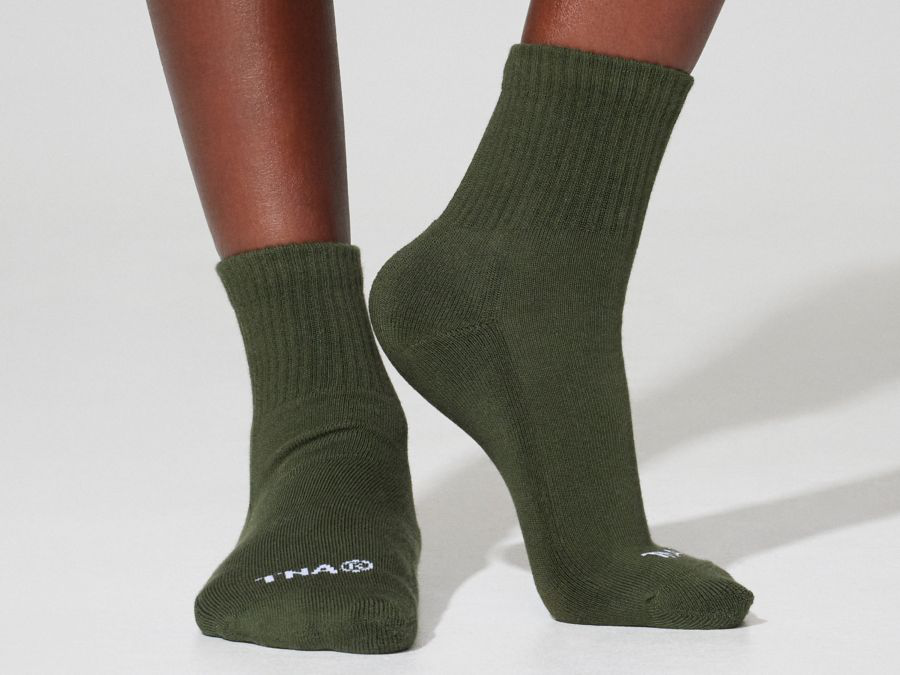

In [74]:
image

In [91]:
image_file_name =  os.path.join("sample_images", os.path.basename(img_url))
image_file_name = os.path.splitext(image_file_name)[0] + ".jpeg"
with open(image_file_name, 'wb') as image_file:
    image_file.write(response.content)

In [84]:
from urllib.parse import urljoin

In [76]:
for img in img_tags:
    img_url = img.get("src")
    if img_url:
        # Handle relative URLs
        mg_url = urljoin(first_row_values[2], img_url)
        img_response = requests.get(img_url)
        if img_response.status_code == 200:
            img_name = os.path.join("downloaded_images", os.path.basename(img_url))
            with open(img_name, "wb") as img_file:
                img_file.write(img_response.content)
                print(f"Downloaded: {img_name}")
        else:
            print(f"Failed to download: {img_url}")

MissingSchema: Invalid URL '//aritzia.scene7.com/is/image/Aritzia/f7f7f7?wid=600': No scheme supplied. Perhaps you meant http:////aritzia.scene7.com/is/image/Aritzia/f7f7f7?wid=600?

In [77]:
first_row_values[2]

'https://www.aritzia.com/us/en/product/cozy-fleece-mega-cargo%E2%84%A2-sweatpant/91985.html?dwvar_91985_color=6448&dwvar_91985_size=14&dwvar_91985_collection=regular'

In [62]:
soup


<!DOCTYPE html>

<html lang="en-US">
<head prefix="og: http://ogp.me/ns# fb: http://ogp.me/ns/fb# aritzia: http://ogp.me/ns/fb/aritzia#">
<link href="https://www.aritzia.com/en/product/cozy-fleece-mega-cargo%E2%84%A2-sweatpant/91985.html" hreflang="en-CA" rel="alternate"/>
<link href="https://www.aritzia.com/fr/product/cozy-fleece-mega-cargo%E2%84%A2-sweatpant/91985.html" hreflang="fr-CA" rel="alternate"/>
<link href="https://www.aritzia.com/us/en/product/cozy-fleece-mega-cargo%E2%84%A2-sweatpant/91985.html" hreflang="en-US" rel="alternate"/>
<link href="https://www.aritzia.com/intl/en/product/cozy-fleece-mega-cargo%E2%84%A2-sweatpant/91985.html" hreflang="x-default" rel="alternate"/>
<link href="https://www.aritzia.com/us/en/product/cozy-fleece-mega-cargo%E2%84%A2-sweatpant/91985.html" rel="canonical"/>
<meta content="COZY FLEECE MEGA CARGO™ SWEATPANT" property="og:title"/>
<meta content="product" property="og:type"/>
<meta content="https://www.aritzia.com/us/en/product/cozy-fleece-m

In [58]:
memory_usage_per_column = df_deets.memory_usage(deep=True)

# Sum up memory usage to get total memory usage of the DataFrame
total_memory_usage = memory_usage_per_column.sum()

# Convert total memory usage from bytes to megabytes (MB)
total_memory_usage_mb = total_memory_usage / (1024 ** 2)

print(f"Total memory usage of the DataFrame: {total_memory_usage_mb:.2f} MB")

Total memory usage of the DataFrame: 0.65 MB


In [59]:
memory_usage_per_column = df.memory_usage(deep=True)

# Sum up memory usage to get total memory usage of the DataFrame
total_memory_usage = memory_usage_per_column.sum()

# Convert total memory usage from bytes to megabytes (MB)
total_memory_usage_mb = total_memory_usage / (1024 ** 2)

print(f"Total memory usage of the DataFrame: {total_memory_usage_mb:.2f} MB")

Total memory usage of the DataFrame: 0.02 MB
